# DeepEnsemble
Technically this is combining the ensemble idea with aleatoric error via a Gaussian NLL loss. I think some call the Gaussian NLL loss approach (where you return the $\mu$ and $\sigma$ of a distribution of the output RV) mean-variance estimation (MVE). 

## The dataset: simple linefit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from scripts import train, models, analysis, io

In [3]:
loss_type = 'bnll_loss'
norm = False
# options are 'no_var_loss' or 'var_loss'
# var_loss is a gaussian negative log likelihood option that incorporates a variance term (for aleatoric uncertainty)

## Load linear data from h5
There are multiple noise options, so define sigma first.

In [4]:
DE_TYPE = 'DE'  
noise = 'low'
# model_name will be used to save the model by checkpoint
model_name = DE_TYPE + '_noise_' + noise
BATCH_SIZE = 100

In [5]:
if noise == 'low':
    sigma = 1
if noise == 'medium':
    sigma = 5
if noise == 'high':
    sigma = 10
if noise == 'vhigh':
    sigma = 100
size_df = 1000

In [6]:
loader = io.DataLoader()

In [7]:
data = loader.load_data_h5('linear_sigma_'+str(sigma)+'_size_'+str(size_df))

In [8]:
data

{'inputs': tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100.]),
 'output': tensor([[ 4.3750e+00,  1.3201e+01,  2.2403e+01,  ...,  8.7229e+02,
           8.8232e+02,  8.8982e+02],
         [ 4.1284e+00,  2.8761e+00,  4.8941e+00,  ...,  3.5861e+01,
           3.2522e+01,  3.5881e+01],
         [-8.1434e+00, -8.6568e+00, -5.0547e+00,  ...,  1.5475e+02,
           1.

In [9]:
len_df = len(data['params'][:,0].numpy())
len_x = len(data['inputs'].numpy())
ms_array = np.repeat(data['params'][:,0].numpy(), len_x)
bs_array = np.repeat(data['params'][:,1].numpy(), len_x)
xs_array = np.tile(data['inputs'].numpy(), len_df)
ys_array = np.reshape(data['output'].numpy(), (len_df * len_x))

In [10]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [11]:
if norm is True:
    print('normalizing')
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    print('input min, max', inputmin, inputmax, 'output min, max', outputmin, outputmax)
    
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    model_inputs = inputs
    model_outputs = ys_array

<Figure size 640x480 with 0 Axes>

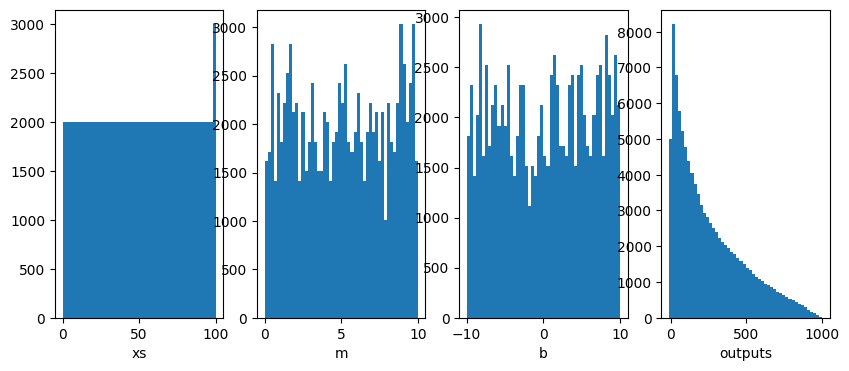

In [12]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

In [13]:
# if they are now normalized (0 - 1) they should have the same distribution as before

(90900, 3) (90900,)
(3,)


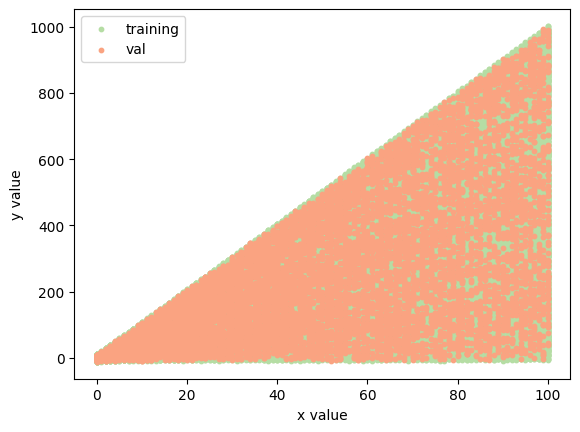

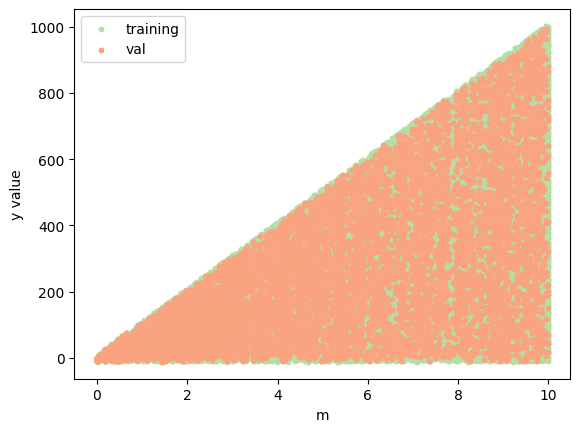

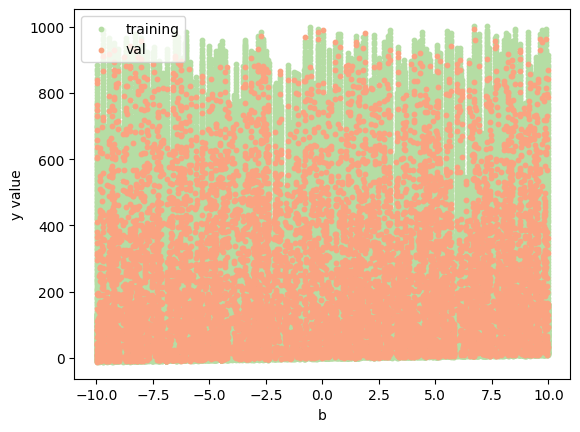

In [14]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [15]:
# okay now prep the training, validation data
trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


In [16]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, lossFn, opt = models.model_setup_DE(loss_type, device, INIT_LR)
print(model)

[INFO] initializing the gal model...
de_var(
  (ln_1): Linear(in_features=3, out_features=100, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (ln_2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (ln_3): Linear(in_features=100, out_features=100, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (ln_4): Linear(in_features=100, out_features=2, bias=True)
)


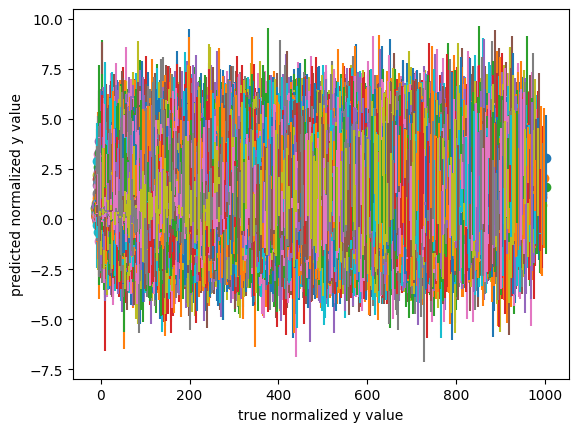

In [17]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    
    if loss_type == 'no_var_loss':
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('true normalized y value')
plt.ylabel('predicted normalized y value')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

looking for saved checkpts []
starting here 0
epoch 0 0.0


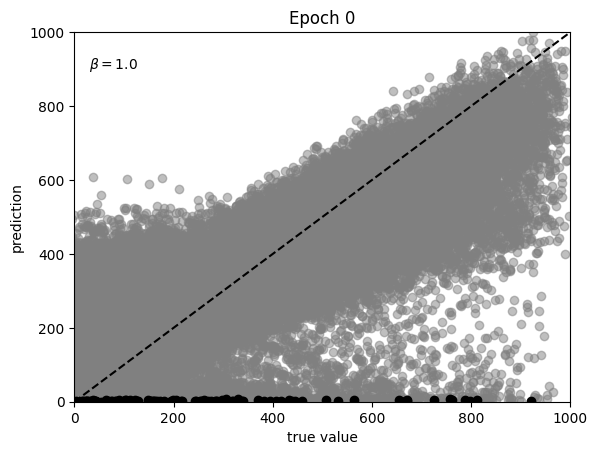

new best loss 136511504.0 in epoch 0
epoch 1 0.0
new best loss 59065892.0 in epoch 1
epoch 2 0.0
new best loss 41590636.0 in epoch 2
epoch 3 0.01
new best loss 37669932.0 in epoch 3
epoch 4 0.01
new best loss 36173912.0 in epoch 4
epoch 5 0.01


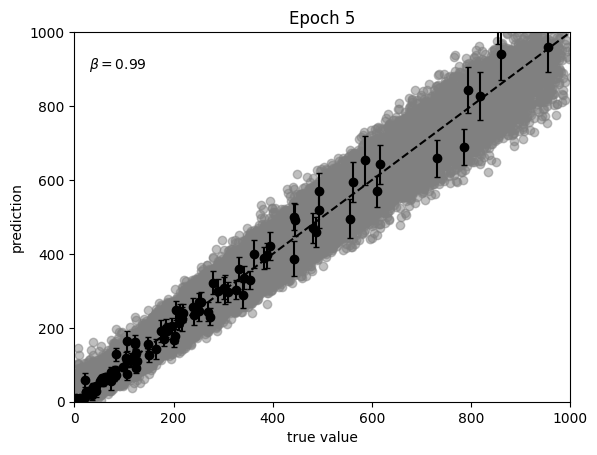

new best loss 32257696.0 in epoch 5
epoch 6 0.01
new best loss 31221546.0 in epoch 6
epoch 7 0.01
new best loss 22419992.0 in epoch 7
epoch 8 0.02
epoch 9 0.02
epoch 10 0.02


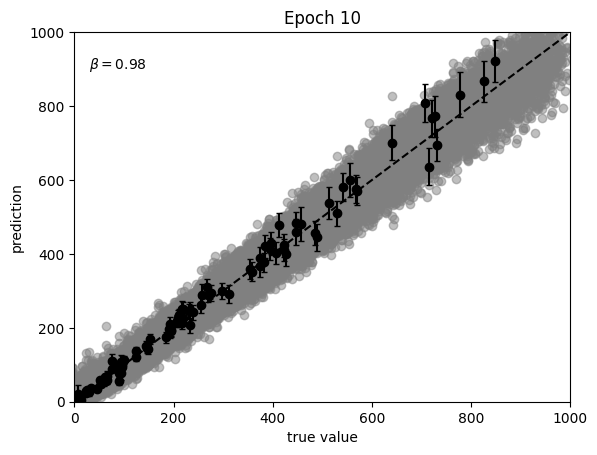

epoch 11 0.02
epoch 12 0.02
epoch 13 0.03
epoch 14 0.03
new best loss 22126976.0 in epoch 14
epoch 15 0.03


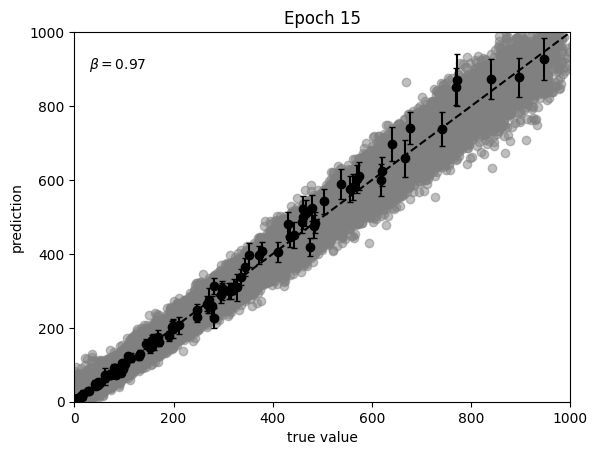

epoch 16 0.03
epoch 17 0.03
epoch 18 0.04
epoch 19 0.04
new best loss 18129120.0 in epoch 19
epoch 20 0.04


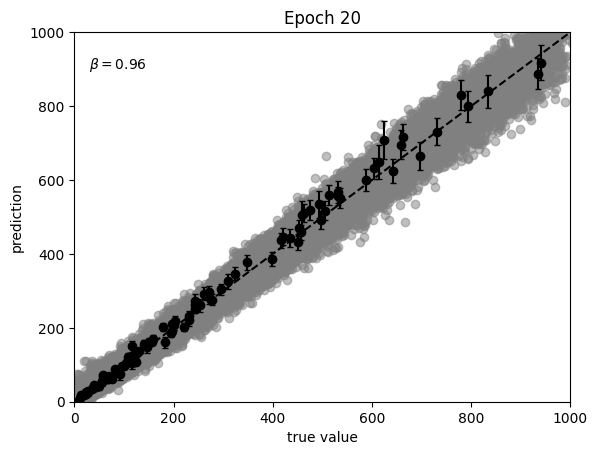

epoch 21 0.04
epoch 22 0.04
epoch 23 0.05
epoch 24 0.05
epoch 25 0.05


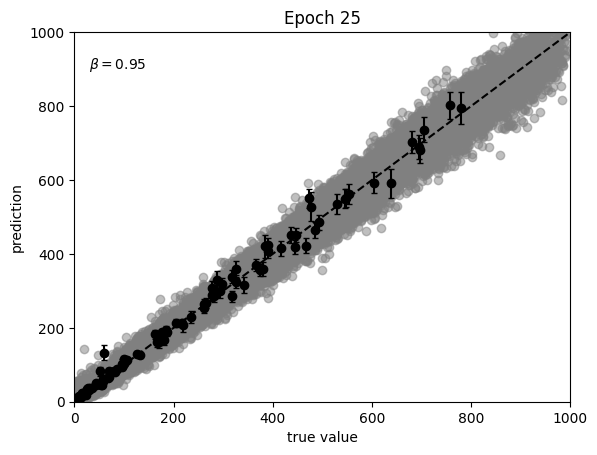

epoch 26 0.05
epoch 27 0.05
epoch 28 0.06
epoch 29 0.06
epoch 30 0.06


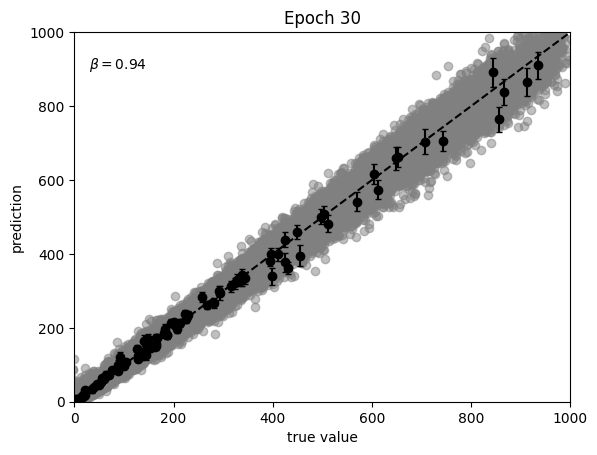

epoch 31 0.06
epoch 32 0.06
epoch 33 0.07
epoch 34 0.07
epoch 35 0.07


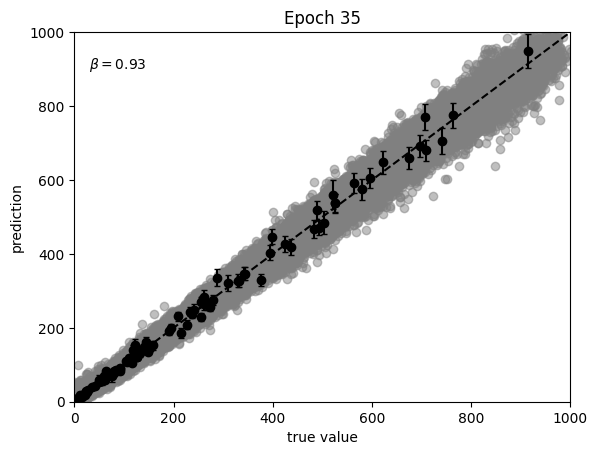

epoch 36 0.07
epoch 37 0.07
epoch 38 0.08
epoch 39 0.08
epoch 40 0.08


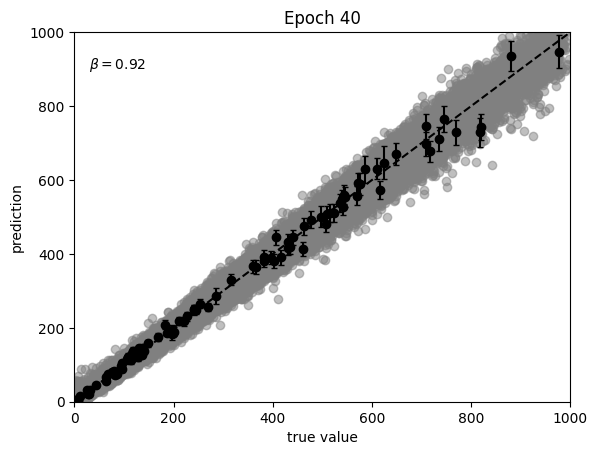

epoch 41 0.08
epoch 42 0.08
epoch 43 0.09
epoch 44 0.09
epoch 45 0.09


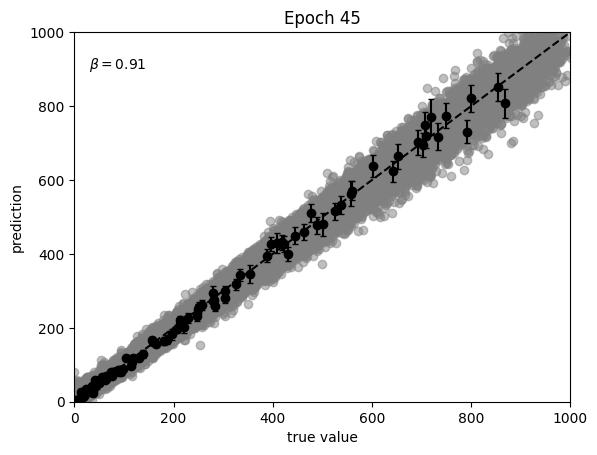

epoch 46 0.09
epoch 47 0.09
epoch 48 0.1
epoch 49 0.1
epoch 50 0.1


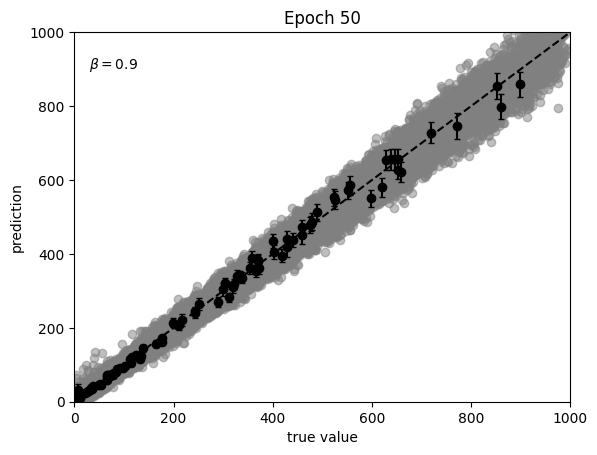

epoch 51 0.1
epoch 52 0.1
epoch 53 0.11
epoch 54 0.11
epoch 55 0.11


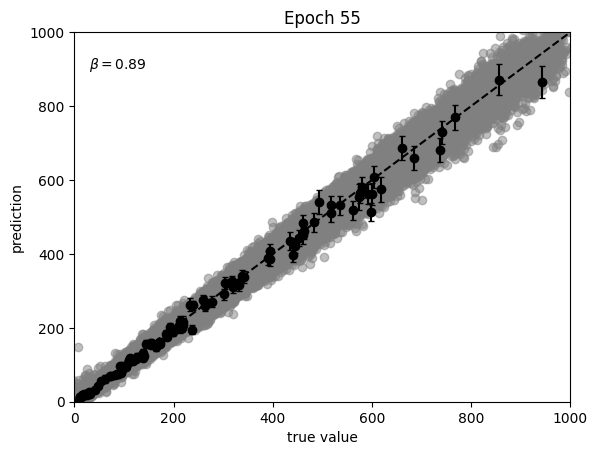

epoch 56 0.11
epoch 57 0.11
epoch 58 0.12
epoch 59 0.12
epoch 60 0.12


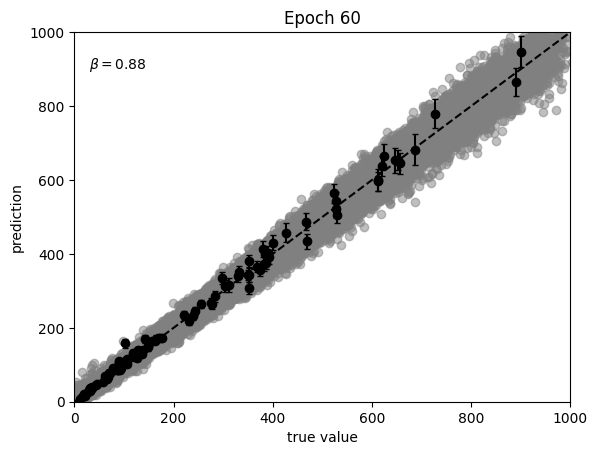

epoch 61 0.12
epoch 62 0.12
epoch 63 0.13
epoch 64 0.13
epoch 65 0.13


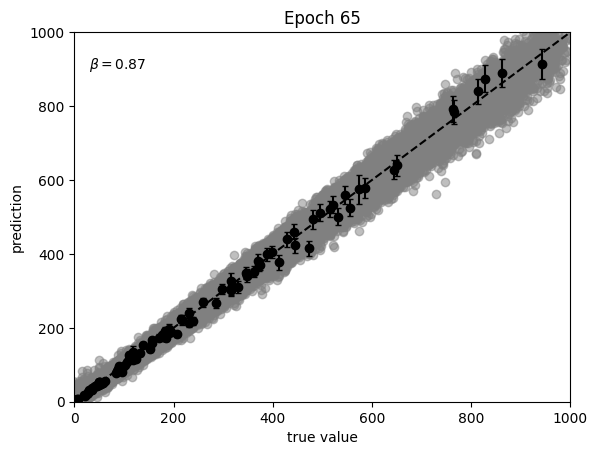

epoch 66 0.13
epoch 67 0.13
epoch 68 0.14
epoch 69 0.14
epoch 70 0.14


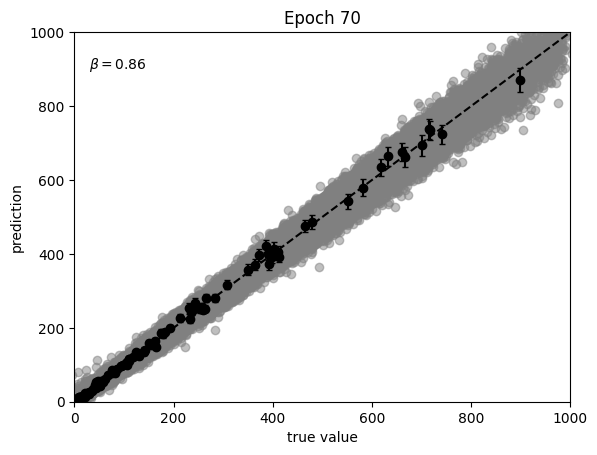

epoch 71 0.14
epoch 72 0.14
epoch 73 0.15
epoch 74 0.15
epoch 75 0.15


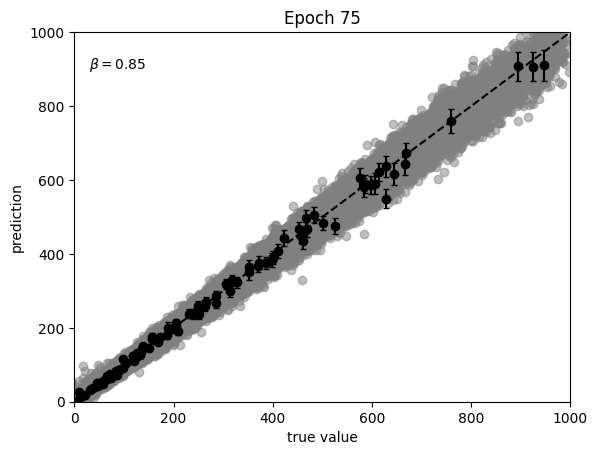

epoch 76 0.15
epoch 77 0.15
epoch 78 0.16
epoch 79 0.16
epoch 80 0.16


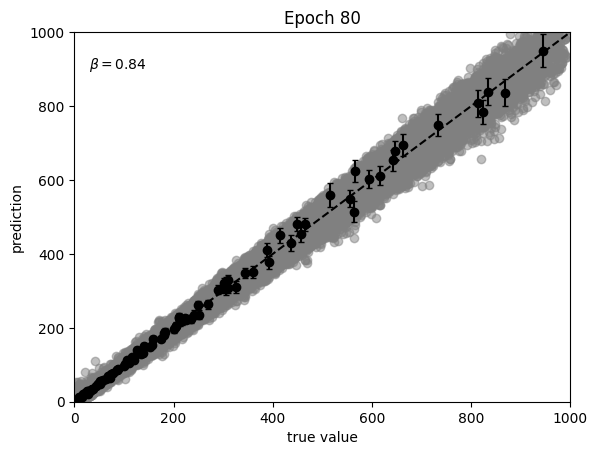

epoch 81 0.16
epoch 82 0.16
epoch 83 0.17
epoch 84 0.17
epoch 85 0.17


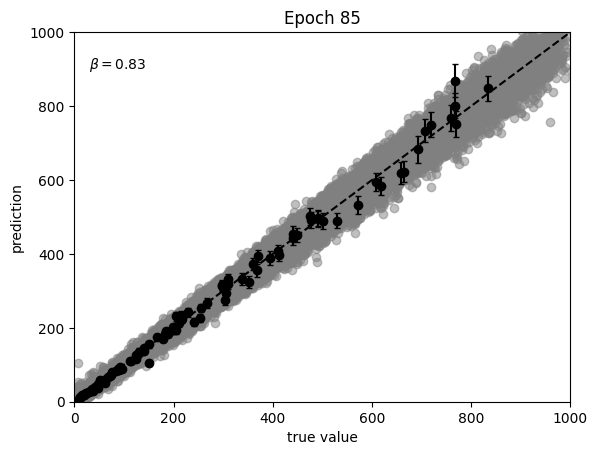

epoch 86 0.17
epoch 87 0.17
epoch 88 0.18
epoch 89 0.18
epoch 90 0.18


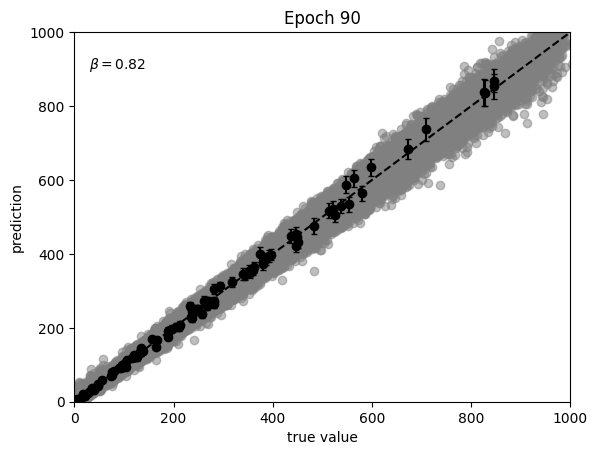

epoch 91 0.18
epoch 92 0.18
epoch 93 0.19
epoch 94 0.19
epoch 95 0.19


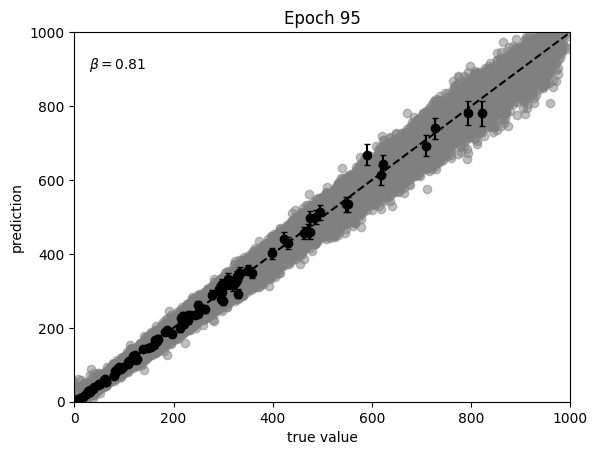

epoch 96 0.19
epoch 97 0.19
epoch 98 0.2
epoch 99 0.2
new best loss 17369838.0 in epoch 99
epoch 100 0.2


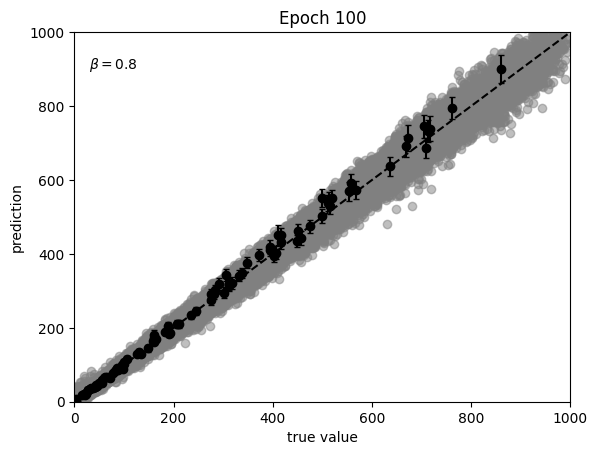

epoch 101 0.2
epoch 102 0.2
epoch 103 0.21
epoch 104 0.21
epoch 105 0.21


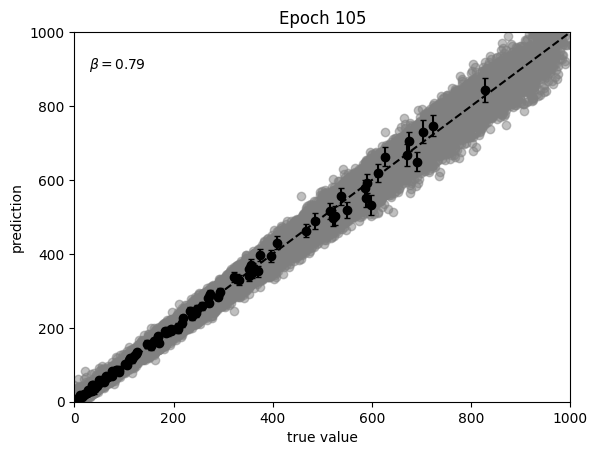

epoch 106 0.21
epoch 107 0.21
epoch 108 0.22
epoch 109 0.22
epoch 110 0.22


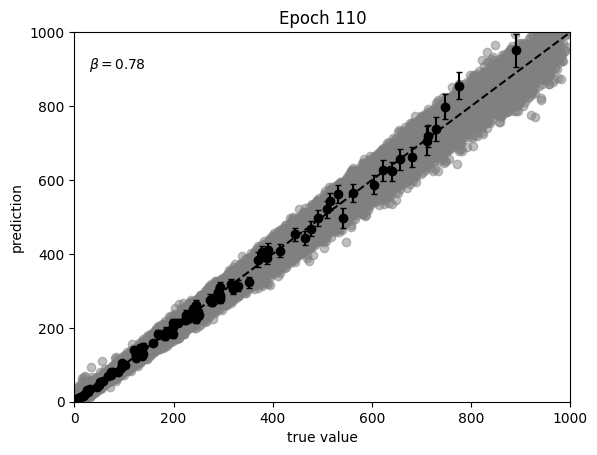

epoch 111 0.22
epoch 112 0.22
epoch 113 0.23
epoch 114 0.23
epoch 115 0.23


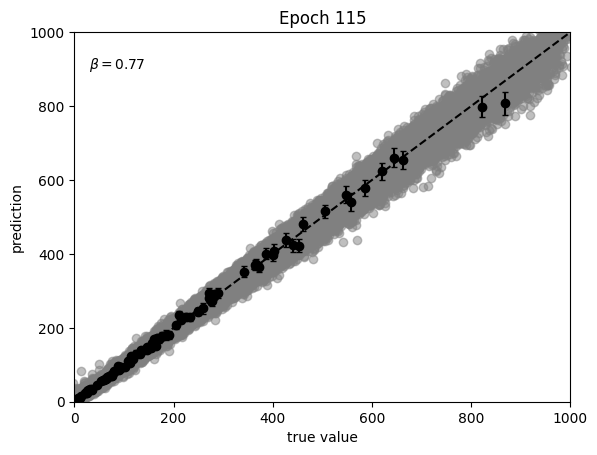

epoch 116 0.23
epoch 117 0.23
epoch 118 0.24
epoch 119 0.24
epoch 120 0.24


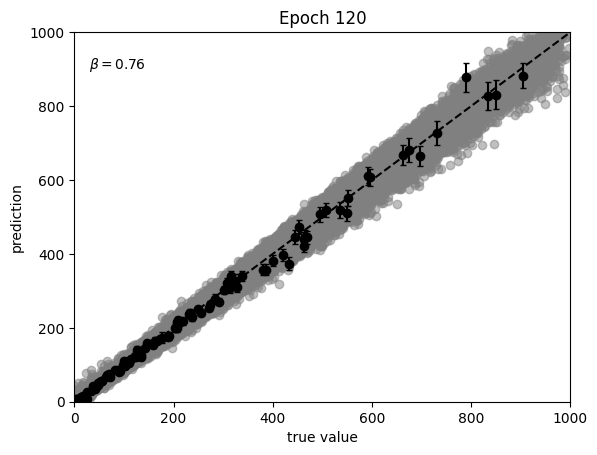

new best loss 17217884.0 in epoch 120
epoch 121 0.24
epoch 122 0.24
epoch 123 0.25
epoch 124 0.25
epoch 125 0.25


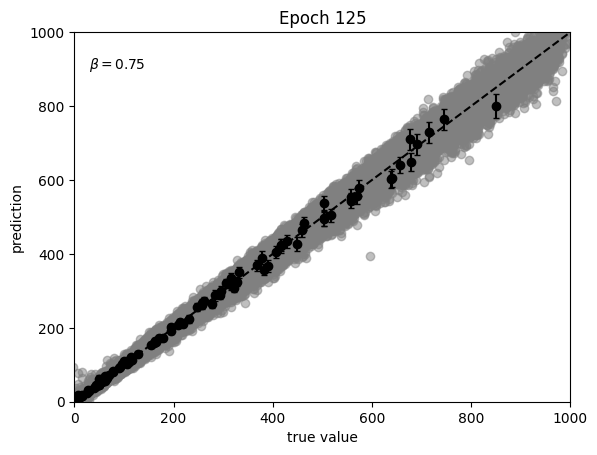

epoch 126 0.25
epoch 127 0.25
epoch 128 0.26
epoch 129 0.26
epoch 130 0.26


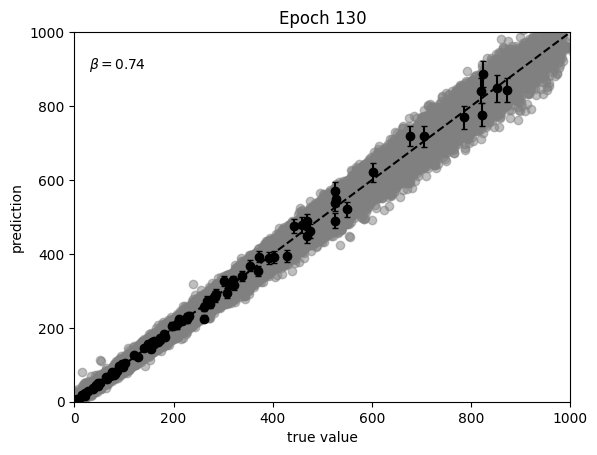

epoch 131 0.26
epoch 132 0.26
epoch 133 0.27
epoch 134 0.27
epoch 135 0.27


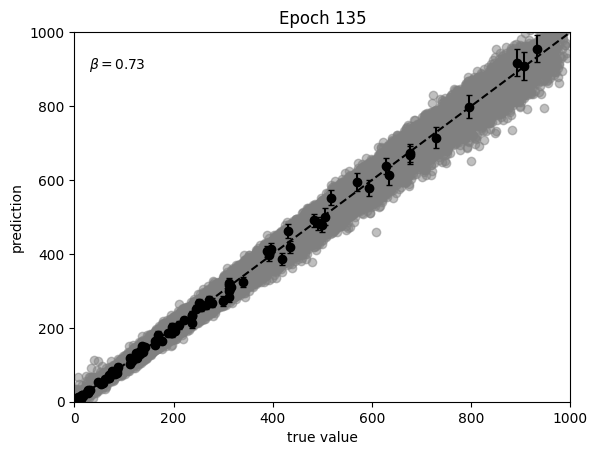

epoch 136 0.27
epoch 137 0.27
epoch 138 0.28
epoch 139 0.28
epoch 140 0.28


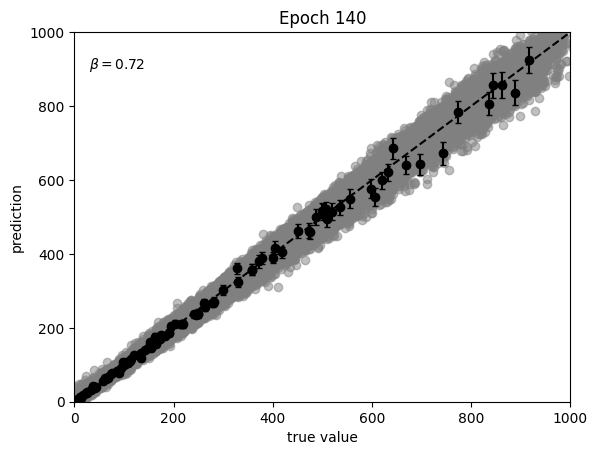

epoch 141 0.28
epoch 142 0.28
epoch 143 0.29
epoch 144 0.29
epoch 145 0.29


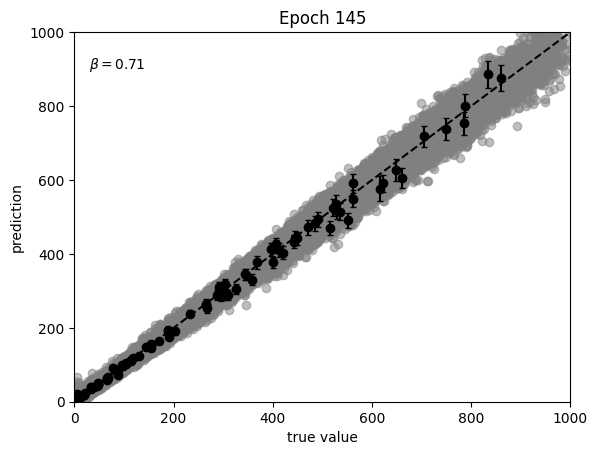

epoch 146 0.29
epoch 147 0.29
epoch 148 0.3
epoch 149 0.3
epoch 150 0.3


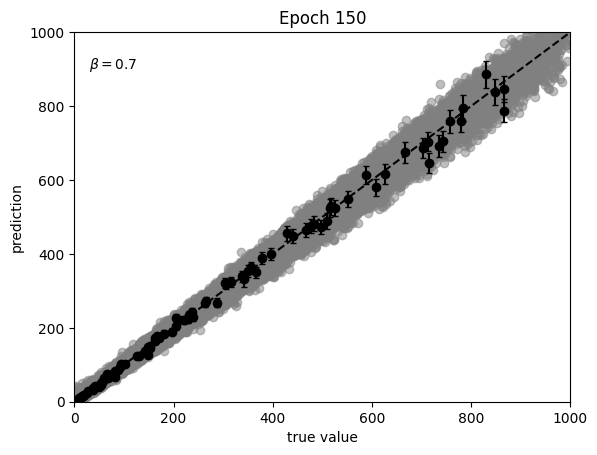

epoch 151 0.3
epoch 152 0.3
epoch 153 0.31
epoch 154 0.31
epoch 155 0.31


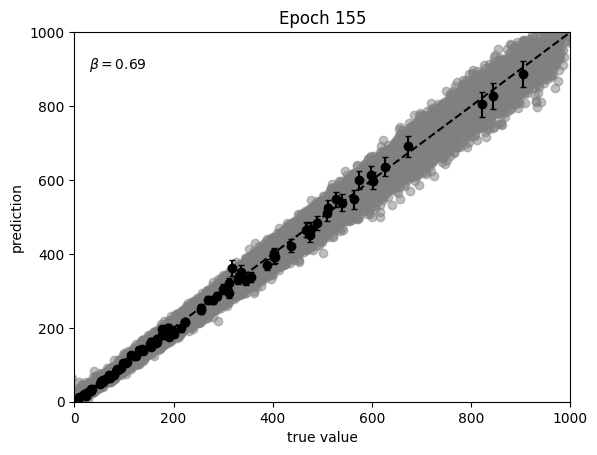

epoch 156 0.31
epoch 157 0.31
epoch 158 0.32
epoch 159 0.32
epoch 160 0.32


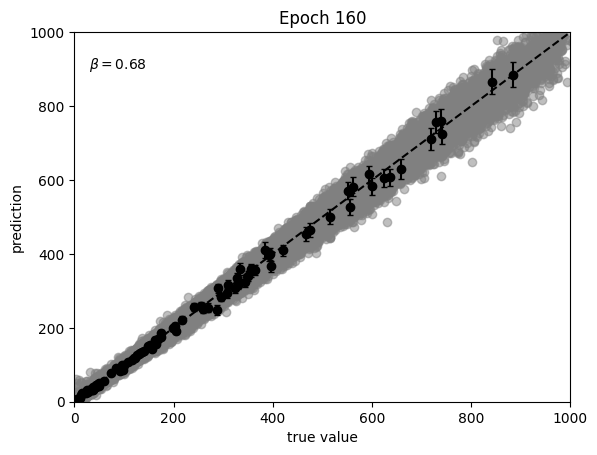

epoch 161 0.32
epoch 162 0.32
epoch 163 0.33
epoch 164 0.33
epoch 165 0.33


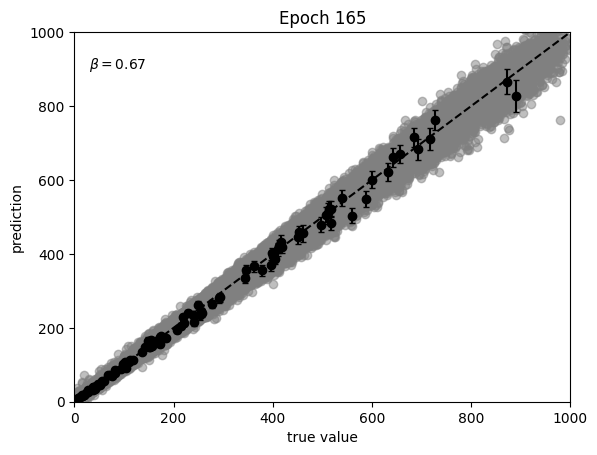

epoch 166 0.33
epoch 167 0.33
epoch 168 0.34
epoch 169 0.34
epoch 170 0.34


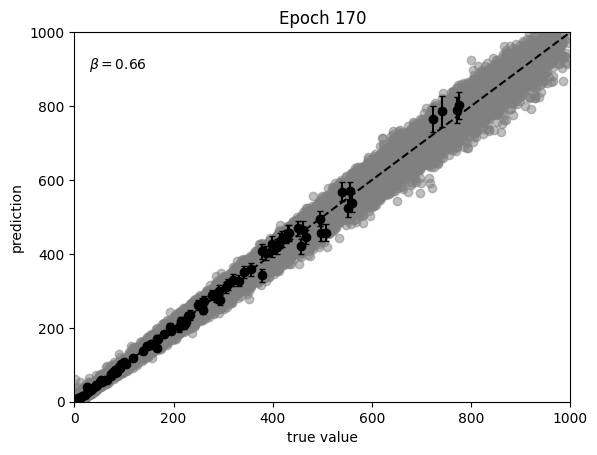

epoch 171 0.34
epoch 172 0.34
epoch 173 0.35
epoch 174 0.35
epoch 175 0.35


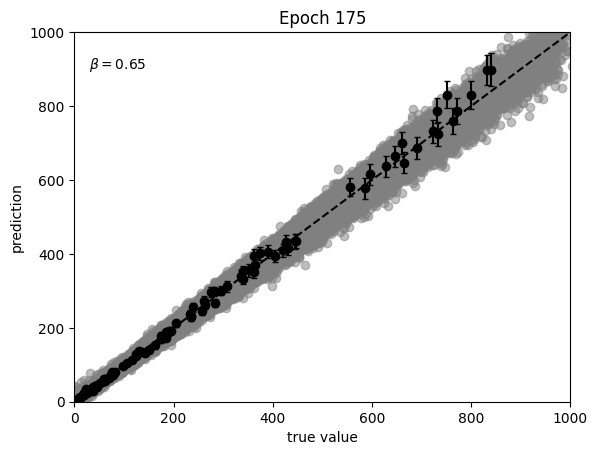

epoch 176 0.35
epoch 177 0.35
epoch 178 0.36
epoch 179 0.36
epoch 180 0.36


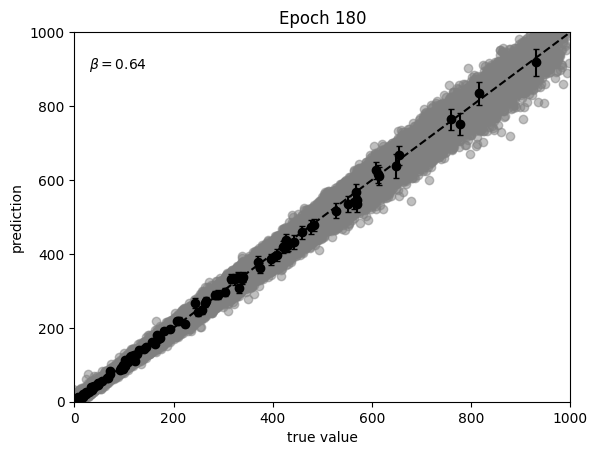

epoch 181 0.36
epoch 182 0.36
epoch 183 0.37
epoch 184 0.37
epoch 185 0.37


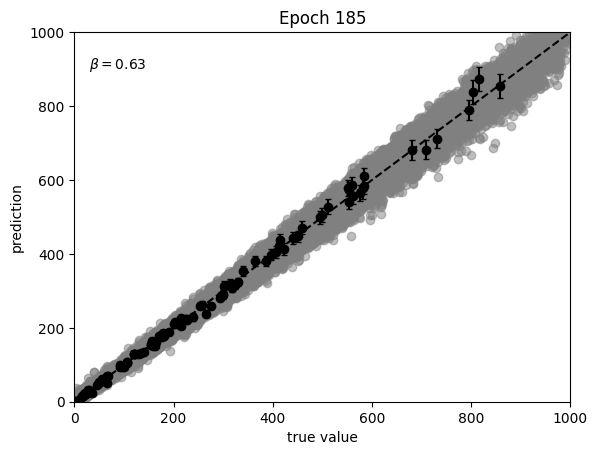

epoch 186 0.37
epoch 187 0.37
epoch 188 0.38
epoch 189 0.38
epoch 190 0.38


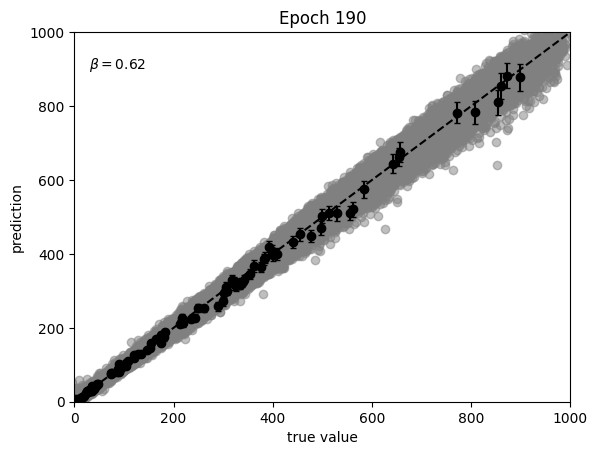

epoch 191 0.38
epoch 192 0.38
epoch 193 0.39
epoch 194 0.39
epoch 195 0.39


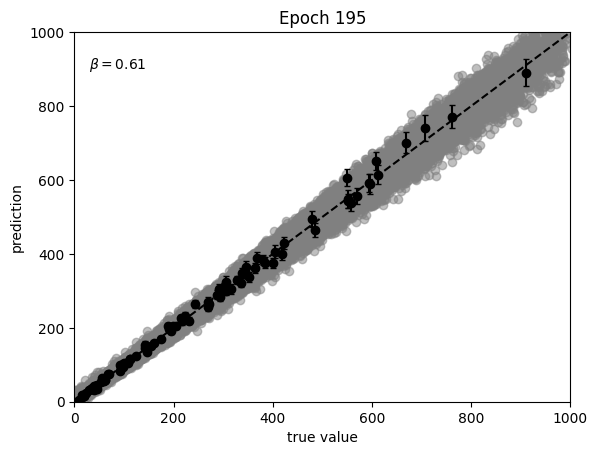

epoch 196 0.39
epoch 197 0.39
epoch 198 0.4
epoch 199 0.4
epoch 200 0.4


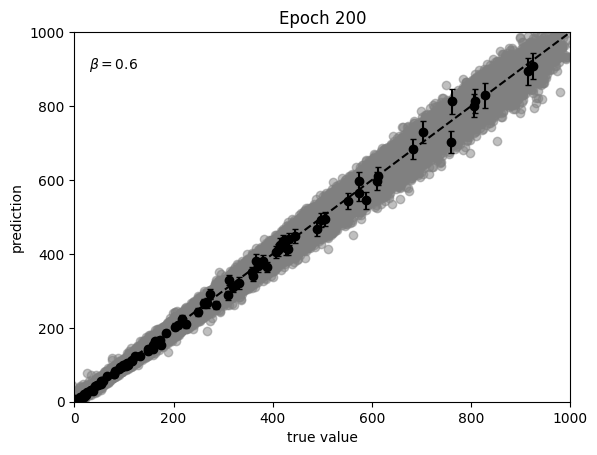

epoch 201 0.4
epoch 202 0.4
epoch 203 0.41
epoch 204 0.41
epoch 205 0.41


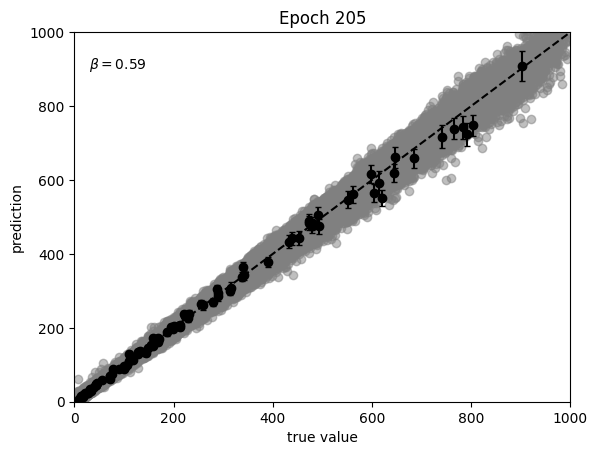

epoch 206 0.41
epoch 207 0.41
epoch 208 0.42
epoch 209 0.42
epoch 210 0.42


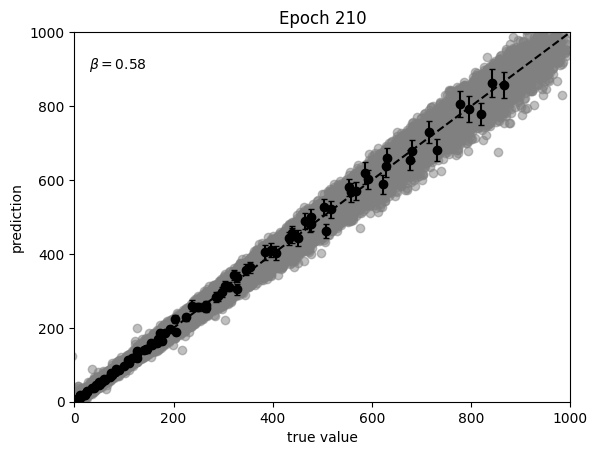

epoch 211 0.42
epoch 212 0.42
epoch 213 0.43
epoch 214 0.43
epoch 215 0.43


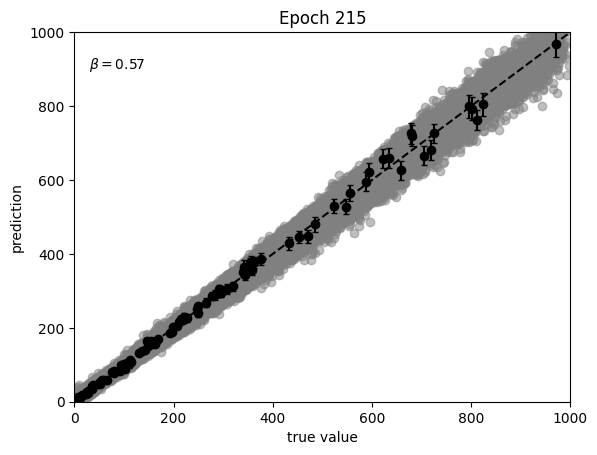

epoch 216 0.43
epoch 217 0.43
epoch 218 0.44
epoch 219 0.44
epoch 220 0.44


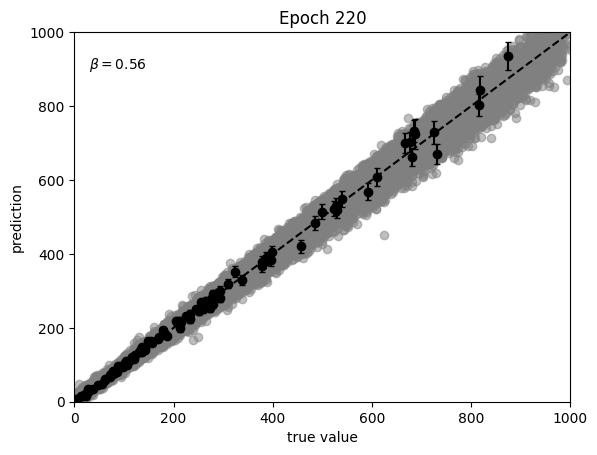

epoch 221 0.44
epoch 222 0.44
epoch 223 0.45
epoch 224 0.45
epoch 225 0.45


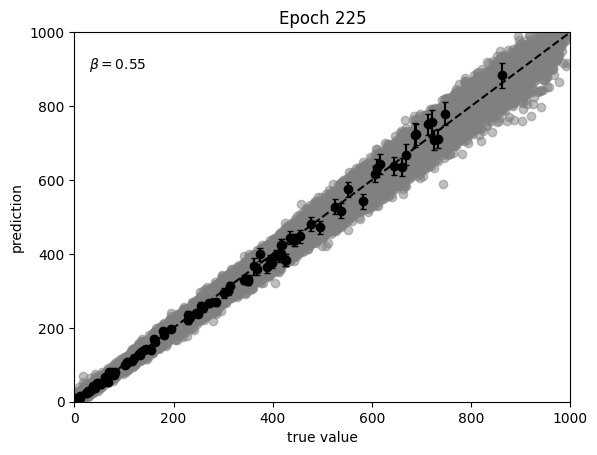

epoch 226 0.45
epoch 227 0.45
epoch 228 0.46
epoch 229 0.46
epoch 230 0.46


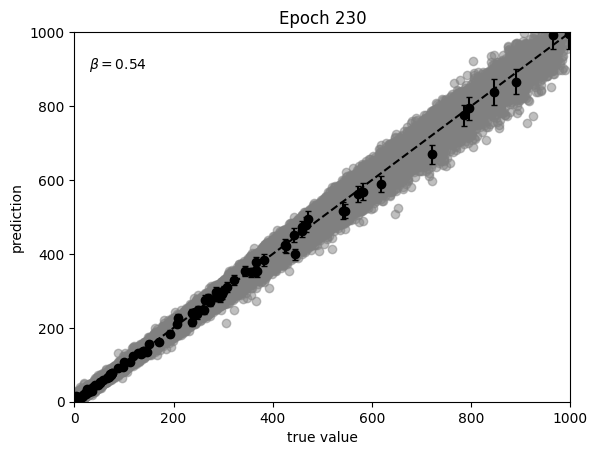

epoch 231 0.46
epoch 232 0.46
epoch 233 0.47
epoch 234 0.47
epoch 235 0.47


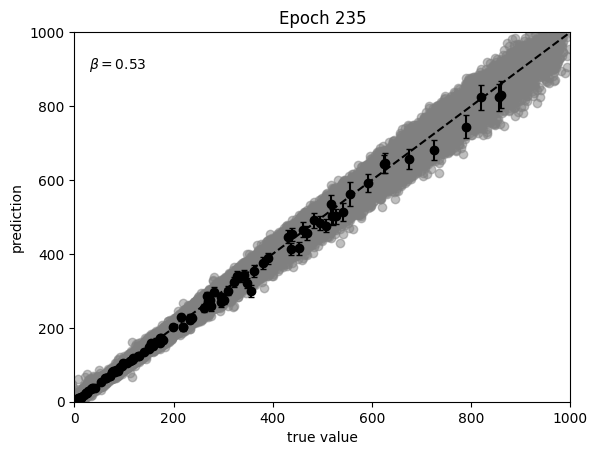

epoch 236 0.47
epoch 237 0.47
epoch 238 0.48
epoch 239 0.48
epoch 240 0.48


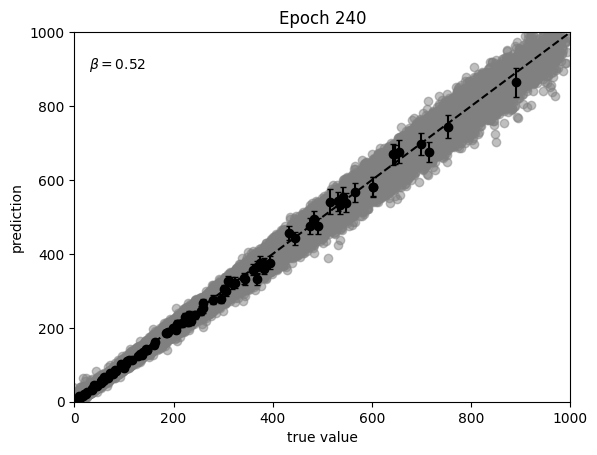

epoch 241 0.48
epoch 242 0.48
epoch 243 0.49
epoch 244 0.49
epoch 245 0.49


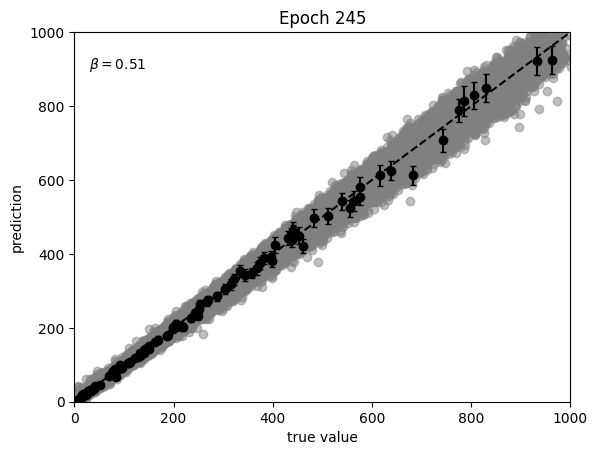

epoch 246 0.49
epoch 247 0.49
epoch 248 0.5
epoch 249 0.5
epoch 250 0.5


In [ ]:
n_models = 5
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             device,
             loss_type,
             n_models,
             model_name,
             EPOCHS=500,
             path_to_model="../models/",
             save_checkpoints=True,
             plot=True,
             savefig=True)
 

## Test the model
To run it through it's paces, draw and one set of (m, b) values and run it through just one of the above trained models from the ensemble. This will work even if you only train one.

In [ ]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use one of the NNs to make a prediction
model = model_ensemble[0]
model.eval()
# first, normalize the x value using the xmin and xmax before
'''
norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys - outputmin) / (outputmax - outputmin)
'''

if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    if loss_type == 'var_loss':
        y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
        y_pred_sigma = abs((y_norm_pred[:,1]) * (outputmax - outputmin) + outputmin)
    else:
        y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
        y_pred_sigma = 0
else:
    y_notnorm_pred = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    if loss_type == 'var_loss':
        y_pred = y_notnorm_pred[:,0]
        y_pred_sigma = abs(y_notnorm_pred[:,1])
    else:
        y_pred = y_notnorm_pred
        y_pred_sigma = 0
    
    

### Aleatoric Error
Aleatoric error can be calculated individually for each model. It is defined using the sigma output from each individual NN.


In [ ]:
# plot
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)
plt.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072')

if loss_type == 'var_loss':
    plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, label = r'NN prediction $u_{al}$', color = '#F7A072')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
plt.title('Aleatoric Error (MVE)')
plt.show()


### Aleatoric error can also be defined from the combination of NNs
$\sigma_{al} = \sqrt{\frac{1}{N}\sum_{n=1}^N \sigma_i^2} = \sqrt{mean(\sigma_i^2)}$

It is the mean of the predicted $\sigma_i$ values from each network.

### Epistemic error is also defined from the ensemble
$\sigma_{ep} = \sqrt{\frac{1}{N}\sum_{n=1}^N\mu_i^2 - mean(\mu_i)^2} = stdev(\mu_i)$

It is the standard deviation of the predicted values $\mu_i$ from each network.

### Plot aleatoric and epistemic error for each model and for the ensemble

In [ ]:
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

# first plot the true values
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)


y_pred_list = []
y_sigma_list = []

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    if norm == 'True':
        y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
        # now un-normalize this so you can plot it
        if loss_type == 'var_loss':
            y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
            y_pred_sigma = abs((y_norm_pred[:,1]) * (outputmax - outputmin) + outputmin)
        else:
            y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
            y_pred_sigma = 0
    else:
        y_notnorm_pred = model(torch.Tensor(thetas_1d_true)).detach().numpy()
        if loss_type == 'var_loss':
            y_pred = y_notnorm_pred[:,0]
            y_pred_sigma = abs(y_notnorm_pred[:,1])
        else:
            y_pred = y_notnorm_pred
            y_pred_sigma = 0
    plt.scatter(x_data, y_pred, label = f'NN prediction {m} aleatoric', color = color_list[m])
    if loss_type == 'var_loss':
        plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, color = color_list[m])
    y_pred_list.append(np.reshape(y_pred, len(x_data)))
    y_sigma_list.append(np.reshape(y_pred_sigma, len(x_data)))
plt.title('Aleatoric Error for each model individually')
plt.legend()
plt.show()

print(np.shape(y_sigma_list), np.shape(y_pred_list))


ensemble_aleatoric_error = np.sqrt(np.mean(np.array(y_sigma_list)**2, axis = 0))
ensemble_epistemic_error = np.std(y_pred_list, axis = 0)

plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)

plt.fill_between(x_data,
                 np.mean(y_pred_list, axis = 0) - ensemble_aleatoric_error,
                 np.mean(y_pred_list, axis = 0) + ensemble_aleatoric_error,
                 color = 'grey', alpha = 0.5,
                 label = r'Ensemble Aleatoric 1$\sigma$ uncertainty')
plt.legend()
plt.title('Ensemble Aleatoric Error')
plt.show()

plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)

plt.fill_between(x_data,
                 np.mean(y_pred_list, axis = 0) - ensemble_epistemic_error,
                 np.mean(y_pred_list, axis = 0) + ensemble_epistemic_error,
                 color = 'grey', alpha = 0.5,
                 label = r'Ensemble Epistemic 1$\sigma$ uncertainty')
plt.legend()
plt.title('Ensemble Epistemic Error')
plt.show()
                 
                 
